## Config Awal

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import math
import warnings
import os
import time

warnings.filterwarnings("ignore")
np.random.seed(42)

Mengimpor beberapa library: numpy dan pandas untuk manipulasi data, matplotlib untuk visualisasi, sklearn untuk scaling dan evaluasi error, serta beberapa modul tambahan seperti os dan time. Baris warnings.filterwarnings("ignore") digunakan untuk menyembunyikan pesan peringatan agar output tetap bersih, sementara np.random.seed(42) memastikan angka acak yang dihasilkan selalu sama (reproducible).

In [ ]:
# ----------------------------
# Pengaturan (ubah jika perlu)
# ----------------------------
future_steps = 12
n_interval_range = range(6, 21)   # 6..20
order_range = range(1, 4)         # 1..3
noise_scale_factor = 0.02         # noise kecil untuk simulasi (scaled space)
z_value = 1.96                    # 95% CI

DATA_FILE = "Data Forecast Emas.csv"

Selanjutnya, sejumlah parameter global ditentukan: jumlah langkah prediksi ke depan (future_steps = 12), range jumlah interval fuzzy (n_interval_range = range(6, 21)), dan range order model (order_range = range(1, 4)) jika nanti ingin menambah lag. Nilai noise_scale_factor mengatur besar kecilnya variasi acak yang ditambahkan ke hasil prediksi, z_value = 1.96 digunakan untuk membentuk batas kepercayaan (confidence interval) 95%, dan DATA_FILE menunjukkan file data utama yang akan dianalisis.

In [ ]:

# ----------------------------
# Utility functions
# ----------------------------
def build_intervals(series_scaled, n_interval):
    low = series_scaled.min()
    high = series_scaled.max()
    edges = np.linspace(low, high, n_interval + 1)
    return edges

def fuzzify_value(value, edges):
    n = len(edges) - 1
    # include rightmost edge
    for i in range(n):
        if edges[i] <= value < edges[i+1]:
            return f"A{i+1}"
    return f"A{n}"

def inverse_transform_array(scaler, arr):
    return scaler.inverse_transform(np.array(arr).reshape(-1,1)).flatten()

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

Fungsi build_intervals() membagi rentang nilai data hasil scaling menjadi sejumlah interval sama panjang, yang kemudian diberi label seperti “A1”, “A2”, dan seterusnya. Fungsi fuzzify_value() mengubah nilai numerik menjadi label fuzzy berdasarkan interval tempatnya berada. Fungsi inverse_transform_array() digunakan untuk mengembalikan nilai yang sebelumnya di-scaling ke skala aslinya, sementara mape() menghitung error dalam bentuk persentase rata-rata absolut. Inti konsep Fuzzy Time Series (FTS) terletak pada proses ini: data kontinu dikonversi ke label fuzzy, lalu aturan (Fuzzy Logical Relationship Group/FLRG) dibangun berdasarkan urutan label tersebut.

## STEP 1

In [ ]:
# ----------------------------
# 1) Read data & EDA ringan
# ----------------------------
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"{DATA_FILE} tidak ditemukan. Pastikan file ada di direktori kerja.")

df = pd.read_csv(DATA_FILE)
print("=== INFO DATA AWAL ===")
print(df.info())
print("\n=== 5 BARIS PERTAMA ===")
print(df.head())

# Pastikan kolom dasar ada
expected = ['Waktu','X1','X2','X3','X4','X5','Xt']
for c in expected:
    if c not in df.columns:
        raise ValueError(f"Kolom {c} tidak ditemukan pada dataset. Pastikan CSV punya kolom: {expected}")

# parse waktu (sama seperti kode sebelumnya)
df['Waktu'] = pd.to_datetime(df['Waktu'], format='%d/%m/%Y %H:%M')
df = df.sort_values('Waktu')


=== INFO DATA AWAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Waktu   92 non-null     object 
 1   X1      92 non-null     float64
 2   X2      92 non-null     float64
 3   X3      92 non-null     float64
 4   X4      92 non-null     int64  
 5   X5      92 non-null     float64
 6   Xt      92 non-null     int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.2+ KB
None

=== 5 BARIS PERTAMA ===
           Waktu      X1      X2      X3     X4         X5      Xt
0  1/1/2018 0:00  0.0325  0.0425  0.0100  13387  866540.51  569763
1  1/2/2018 0:00  0.0318  0.0425  0.0107  13740  846933.60  579873
2  1/3/2018 0:00  0.0340  0.0425  0.0085  13760  893574.40  583934
3  1/4/2018 0:00  0.0341  0.0425  0.0084  13910  953808.70  594163
4  1/5/2018 0:00  0.0323  0.0450  0.0127  13890  931185.60  589993


pembacaan file data dan eksplorasi awal (Exploratory Data Analysis). Dataset dibaca menggunakan pd.read_csv(), lalu kolom Waktu dikonversi menjadi tipe datetime agar bisa diurutkan secara kronologis. Fungsi info() dan head() digunakan untuk memastikan struktur dan contoh isi data sudah benar. Ringkasan statistik (describe()) memberikan gambaran umum tentang sebaran nilai pada tiap kolom, misalnya nilai rata-rata, minimum, maksimum, dan standar deviasi. Pemeriksaan isna().sum() memastikan tidak ada data kosong. Visualisasi kemudian dibuat berupa plot tren harga emas (Xt) terhadap waktu, heatmap korelasi antarvariabel (X1–X5 dan Xt), serta boxplot untuk mendeteksi outlier. Dari hasilnya terlihat bahwa Xt memiliki rentang nilai yang cukup besar dan outlier di sisi kanan, serta ada korelasi cukup kuat antara Xt dan X4. Tahap EDA ini penting untuk memahami pola data sebelum masuk ke tahap fuzzifikasi.

In [ ]:
print("\n=== STATISTIK DESKRIPTIF ===")
print(df[['X1','X2','X3','X4','X5','Xt']].describe())

print("\n=== MISSING VALUES ===")
print(df.isna().sum())


=== STATISTIK DESKRIPTIF ===
              X1         X2         X3            X4            X5  \
count  92.000000  92.000000  92.000000     92.000000  9.200000e+01   
mean    0.027760   0.049620   0.022582  14903.043478  1.013174e+06   
std     0.010894   0.009924   0.012648    833.319799  2.724107e+05   
min    -0.000900   0.035000   0.000100  13387.000000  2.799624e+05   
25%     0.020575   0.040000   0.013125  14250.000000  8.249587e+05   
50%     0.027350   0.052500   0.022550  14680.000000  1.056293e+06   
75%     0.032550   0.057500   0.031475  15516.250000  1.197813e+06   
max     0.055100   0.062500   0.058400  16600.000000  1.674182e+06   

                 Xt  
count  9.200000e+01  
mean   9.659946e+05  
std    2.931115e+05  
min    5.697630e+05  
25%    7.737500e+05  
50%    9.350000e+05  
75%    1.030680e+06  
max    1.826020e+06  

=== MISSING VALUES ===
Waktu    0
X1       0
X2       0
X3       0
X4       0
X5       0
Xt       0
dtype: int64


Membaca file data dan eksplorasi awal (Exploratory Data Analysis). Dataset dibaca menggunakan pd.read_csv(), lalu kolom Waktu dikonversi menjadi tipe datetime agar bisa diurutkan secara kronologis. Fungsi info() dan head() digunakan untuk memastikan struktur dan contoh isi data sudah benar. Ringkasan statistik (describe()) memberikan gambaran umum tentang sebaran nilai pada tiap kolom, misalnya nilai rata-rata, minimum, maksimum, dan standar deviasi. Pemeriksaan isna().sum() memastikan tidak ada data kosong. Visualisasi kemudian dibuat berupa plot tren harga emas (Xt) terhadap waktu, heatmap korelasi antarvariabel (X1–X5 dan Xt), serta boxplot untuk mendeteksi outlier. Dari hasilnya terlihat bahwa Xt memiliki rentang nilai yang cukup besar dan outlier di sisi kanan, serta ada korelasi cukup kuat antara Xt dan X4. Tahap EDA ini penting untuk memahami pola data sebelum masuk ke tahap fuzzifikasi.

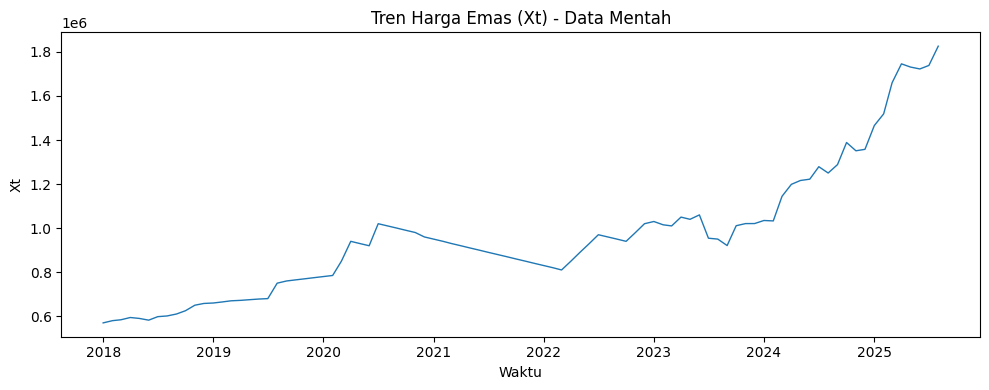

Saved eda_trend.png


In [ ]:
# Plot tren Xt (raw)
plt.figure(figsize=(10,4))
plt.plot(df['Waktu'], df['Xt'], linewidth=1)
plt.title("Tren Harga Emas (Xt) - Data Mentah")
plt.xlabel("Waktu")
plt.ylabel("Xt")
plt.tight_layout()
plt.savefig("eda_trend.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved eda_trend.png")


=== KORELASI ANTAR VARIABEL ===
          X1        X2        X3        X4        X5        Xt
X1  1.000000  0.114543 -0.667862 -0.130726  0.319509 -0.358081
X2  0.114543  1.000000  0.623219  0.499334  0.095101  0.266230
X3 -0.667862  0.623219  1.000000  0.507664 -0.116117  0.515594
X4 -0.130726  0.499334  0.507664  1.000000  0.394231  0.819351
X5  0.319509  0.095101 -0.116117  0.394231  1.000000  0.259083
Xt -0.358081  0.266230  0.515594  0.819351  0.259083  1.000000


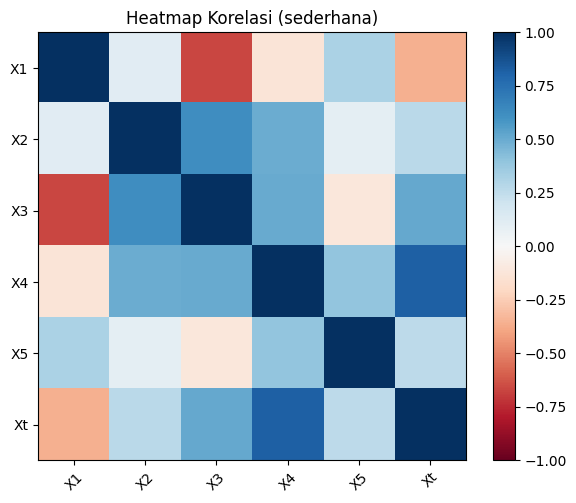

Saved eda_heatmap.png


In [ ]:
# korelasi
corr = df[['X1','X2','X3','X4','X5','Xt']].corr()
print("\n=== KORELASI ANTAR VARIABEL ===")
print(corr)

# heatmap korelasi sederhana
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Heatmap Korelasi (sederhana)")
plt.tight_layout()
plt.savefig("eda_heatmap.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved eda_heatmap.png")

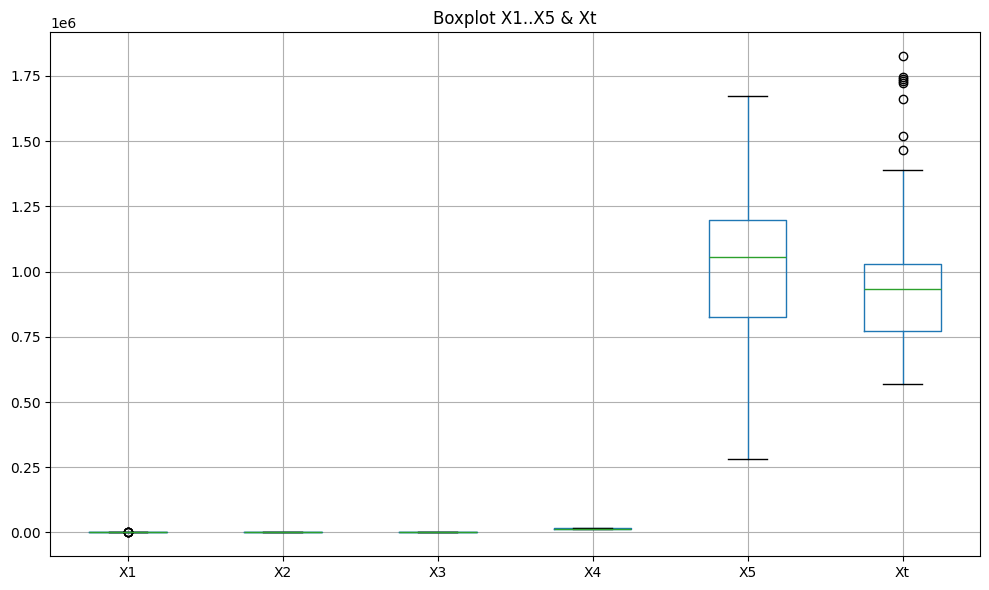

Saved eda_boxplots.png


In [ ]:
# boxplots untuk cek outlier
plt.figure(figsize=(10,6))
df[['X1','X2','X3','X4','X5','Xt']].boxplot()
plt.title("Boxplot X1..X5 & Xt")
plt.tight_layout()
plt.savefig("eda_boxplots.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved eda_boxplots.png")

Visualisasi kemudian dibuat berupa plot tren harga emas (Xt) terhadap waktu, heatmap korelasi antarvariabel (X1–X5 dan Xt), serta boxplot untuk mendeteksi outlier. Dari hasilnya terlihat bahwa Xt memiliki rentang nilai yang cukup besar dan outlier di sisi kanan, serta ada korelasi cukup kuat antara Xt dan X4. Tahap EDA ini penting untuk memahami pola data sebelum masuk ke tahap fuzzifikasi.

## STEP 2

In [ ]:
# ----------------------------
# 2) Agregasi bulanan (sama seperti kode sebelumnya)
# ----------------------------
df['month'] = df['Waktu'].dt.to_period('M')
monthly = df.groupby('month').mean().reset_index()
monthly['month'] = monthly['month'].dt.to_timestamp()

monthly_df = monthly[['month','X1','X2','X3','X4','X5','Xt']].copy()
#monthly_df.to_csv("01_data_bulanan_no_pca.csv", index=False)
print("Saved 01_data_bulanan_no_pca.csv")
print("\n=== 5 BARIS DATA BULANAN ===")
print(monthly_df.head())

Saved 01_data_bulanan_no_pca.csv

=== 5 BARIS DATA BULANAN ===
       month      X1      X2      X3       X4         X5        Xt
0 2018-01-01  0.0325  0.0425  0.0100  13387.0  866540.51  569763.0
1 2018-02-01  0.0318  0.0425  0.0107  13740.0  846933.60  579873.0
2 2018-03-01  0.0340  0.0425  0.0085  13760.0  893574.40  583934.0
3 2018-04-01  0.0341  0.0425  0.0084  13910.0  953808.70  594163.0
4 2018-05-01  0.0323  0.0450  0.0127  13890.0  931185.60  589993.0


Data diubah dari format harian menjadi bulanan dengan menghitung rata-rata tiap kolom untuk setiap bulan. Hal ini dilakukan agar pola jangka panjang lebih mudah terlihat dan noise jangka pendek berkurang. Kolom baru bernama month dibuat dari kolom waktu (Waktu), kemudian data dikelompokkan (groupby) dan dihitung rata-ratanya. Hasil akhirnya disimpan dalam monthly_df, yang berisi kolom waktu bulanan dan variabel X1–X5 serta Xt. Proses agregasi ini merupakan langkah penting dalam analisis time series karena membantu mengurangi fluktuasi kecil dan menonjolkan tren yang lebih stabil.

## STEP 3

In [ ]:
# ----------------------------
# 3) Scaling per series (MinMax)
# ----------------------------
scalers = {}
scaled = pd.DataFrame()
for col in ['X1','X2','X3','X4','X5','Xt']:
    scaler = MinMaxScaler().fit(monthly_df[[col]])
    scalers[col] = scaler
    scaled[col] = scaler.transform(monthly_df[[col]]).flatten()

Menyiapkan data agar berada dalam rentang yang seragam, yaitu 0 hingga 1, menggunakan MinMaxScaler. Scaling diperlukan karena tiap variabel (misalnya X1 dan X5) bisa memiliki skala yang sangat berbeda — tanpa scaling, pembentukan interval fuzzy bisa jadi tidak seimbang. Untuk setiap kolom (X1 hingga Xt), scaler dilatih (fit) dan hasil scaling disimpan dalam scaled. Objek scaler juga disimpan di dictionary scalers agar nanti bisa digunakan kembali untuk mengembalikan nilai hasil prediksi ke skala aslinya.

## optional

In [ ]:
def get_uod(series, margin_ratio=0):
    min_val = series.min()
    max_val = series.max()
    margin = (max_val - min_val) * margin_ratio
    return min_val - margin, max_val + margin

def build_labels_for_intervals(df, n_interval, margin_ratio=0):
    edges_all = {}
    labels_all = {}
    for col in df.columns:
        uod_min, uod_max = get_uod(df[col], margin_ratio)
        edges = np.linspace(uod_min, uod_max, n_interval + 1)
        edges_all[col] = edges
        labels = []
        for val in df[col]:
            for i in range(len(edges)-1):
                if edges[i] <= val < edges[i+1]:
                    labels.append(f"A{i+1}")
                    break
            else:
                if val == edges[-1]:
                    labels.append(f"A{n_interval}")
                else:
                    labels.append(None)
        labels_all[col] = labels
        print(f"{col} interval edges: {edges}")  # Print untuk cek range
    return edges_all, labels_all

# Contoh penggunaan di pipeline tuning/autotune:
n_interval = 21         # atau rentang autotuning
edges_all, labels_all = build_labels_for_intervals(
    monthly_df[['X1', 'X2', 'X3', 'X4', 'X5', 'Xt']], n_interval, margin_ratio=0)

# Selanjutnya proses FLRG, forecast historis, evaluasi, dst


X1 interval edges: [-0.0009      0.00176667  0.00443333  0.0071      0.00976667  0.01243333
  0.0151      0.01776667  0.02043333  0.0231      0.02576667  0.02843333
  0.0311      0.03376667  0.03643333  0.0391      0.04176667  0.04443333
  0.0471      0.04976667  0.05243333  0.0551    ]
X2 interval edges: [0.035      0.03630952 0.03761905 0.03892857 0.0402381  0.04154762
 0.04285714 0.04416667 0.04547619 0.04678571 0.04809524 0.04940476
 0.05071429 0.05202381 0.05333333 0.05464286 0.05595238 0.0572619
 0.05857143 0.05988095 0.06119048 0.0625    ]
X3 interval edges: [0.0001     0.00287619 0.00565238 0.00842857 0.01120476 0.01398095
 0.01675714 0.01953333 0.02230952 0.02508571 0.0278619  0.0306381
 0.03341429 0.03619048 0.03896667 0.04174286 0.04451905 0.04729524
 0.05007143 0.05284762 0.05562381 0.0584    ]
X4 interval edges: [13387. 13540. 13693. 13846. 13999. 14152. 14305. 14458. 14611. 14764.
 14917. 15070. 15223. 15376. 15529. 15682. 15835. 15988. 16141. 16294.
 16447. 16600.]
X5 in

In [ ]:
# ===== 2. FUZZIFIKASI =====
def build_labels_for_intervals(df, n_interval, margin_ratio=0.05):
    edges_all = {}
    labels_all = {}
    for col in df.columns:
        uod_min, uod_max = get_uod(df[col], margin_ratio)
        edges = np.linspace(uod_min, uod_max, n_interval + 1)
        edges_all[col] = edges
        labels = []
        for val in df[col]:
            for i in range(len(edges)-1):
                if edges[i] <= val < edges[i+1]:
                    labels.append(f"A{i+1}")
                    break
            else:
                if val == edges[-1]:
                    labels.append(f"A{n_interval}")
                else:
                    labels.append(None)
        labels_all[col] = labels
        print(f"Interval {col}: {edges}")  # Output interval setiap kolom
    return edges_all, labels_all

n_interval = 21
edges_all, labels_all = build_labels_for_intervals(
    monthly_df[['X1', 'X2', 'X3', 'X4', 'X5', 'Xt']], n_interval, margin_ratio=0.05)

# Sample output for label mapping
fuzzified_df = pd.DataFrame(labels_all)
print("\n=== Sample Fuzzifikasi Data (5 Baris) ===")
print(fuzzified_df.head())


Interval X1: [-0.0037     -0.00076667  0.00216667  0.0051      0.00803333  0.01096667
  0.0139      0.01683333  0.01976667  0.0227      0.02563333  0.02856667
  0.0315      0.03443333  0.03736667  0.0403      0.04323333  0.04616667
  0.0491      0.05203333  0.05496667  0.0579    ]
Interval X2: [0.033625   0.03506548 0.03650595 0.03794643 0.0393869  0.04082738
 0.04226786 0.04370833 0.04514881 0.04658929 0.04802976 0.04947024
 0.05091071 0.05235119 0.05379167 0.05523214 0.05667262 0.0581131
 0.05955357 0.06099405 0.06243452 0.063875  ]
Interval X3: [-0.002815    0.00023881  0.00329262  0.00634643  0.00940024  0.01245405
  0.01550786  0.01856167  0.02161548  0.02466929  0.0277231   0.0307769
  0.03383071  0.03688452  0.03993833  0.04299214  0.04604595  0.04909976
  0.05215357  0.05520738  0.05826119  0.061315  ]
Interval X4: [13226.35 13394.65 13562.95 13731.25 13899.55 14067.85 14236.15 14404.45
 14572.75 14741.05 14909.35 15077.65 15245.95 15414.25 15582.55 15750.85
 15919.15 16087.45 

In [ ]:
# Distribusi cluster/label
print("\n=== Distribusi label fuzzy per variabel ===")
for col in fuzzified_df.columns:
    print(f"{col}:")
    print(fuzzified_df[col].value_counts().sort_index())


=== Distribusi label fuzzy per variabel ===
X1:
X1
A1      1
A10     7
A11    13
A12    13
A13    13
A14     4
A15     1
A17     3
A18     2
A19     2
A20     3
A21     1
A4      1
A5      1
A6      3
A7     11
A8      6
A9      7
Name: count, dtype: int64
X2:
X2
A1     16
A10     3
A12     6
A14     3
A15     5
A17    17
A19    17
A21     5
A3      6
A5      4
A7      6
A8      4
Name: count, dtype: int64
X3:
X3
A1      2
A10    10
A11     5
A12     5
A13     7
A14     3
A15     3
A16     3
A17     1
A18     1
A2      4
A21     1
A3      4
A4      7
A5      4
A6      8
A7      6
A8      9
A9      9
Name: count, dtype: int64
X4:
X4
A1      1
A10     7
A11     4
A12     5
A13     2
A14     5
A15     3
A16     4
A18     5
A19     4
A20     4
A21     1
A3      1
A4      4
A5      6
A6      8
A7     15
A8      8
A9      5
Name: count, dtype: int64
X5:
X5
A1      1
A10     5
A11     8
A12    12
A13     9
A14     9
A15     8
A16     6
A17     2
A18     2
A19     1
A2      1
A21     1
A5    

In [ ]:
# ===== 3. FLRG Building =====
FLRG = {}
Xt_labels = fuzzified_df['Xt'].tolist()
factor_labels = {f"X{i}": fuzzified_df[f"X{i}"].tolist() for i in range(1,6)}
for t in range(1, len(fuzzified_df)):
    key = tuple(factor_labels[f"X{i}"][t] for i in range(1,6))
    tgt = Xt_labels[t]
    if key not in FLRG:
        FLRG[key] = []
    if tgt not in FLRG[key]:
        FLRG[key].append(tgt)

In [ ]:
# Output jumlah rule dan sample
flrg_rows = []
for k, v in FLRG.items():
    flrg_rows.append({'Antecedent (X1..X5)': ' , '.join(k), 'Consequent (Xt)': ' , '.join(v)})
flrg_df = pd.DataFrame(flrg_rows)
print("\n=== Sample FLRG (5 Baris) ===")
print(flrg_df.head())
print("Total FLRG (rule):", len(flrg_df))


=== Sample FLRG (5 Baris) ===
         Antecedent (X1..X5) Consequent (Xt)
0    A13 , A7 , A5 , A4 , A9              A2
1   A13 , A7 , A4 , A4 , A10              A2
2   A13 , A7 , A4 , A5 , A11              A2
3   A13 , A8 , A6 , A4 , A10              A2
4  A12 , A10 , A7 , A7 , A12              A2
Total FLRG (rule): 90


In [ ]:
# ===== 4. Statistik Label Consequent pada FLRG (A1, A2, dst) =====
flrg_df['consequents'] = flrg_df['Consequent'].apply(lambda x: [s.strip() for s in x.split(' , ')])
all_consequents = [item for sublist in flrg_df['consequents'] for item in sublist]
label_flr_counts = collections.Counter(all_consequents)
print("\n=== Statistik jumlah label fuzzy pada consequent FLRG ===")
for label, count in sorted(label_flr_counts.items()):
    print(f"{label}: {count}")


=== Statistik jumlah label fuzzy pada consequent FLRG ===
A1: 9
A10: 1
A11: 4
A12: 2
A13: 2
A14: 1
A15: 1
A16: 1
A18: 1
A19: 4
A2: 9
A20: 1
A3: 1
A4: 8
A5: 8
A6: 13
A7: 10
A8: 14


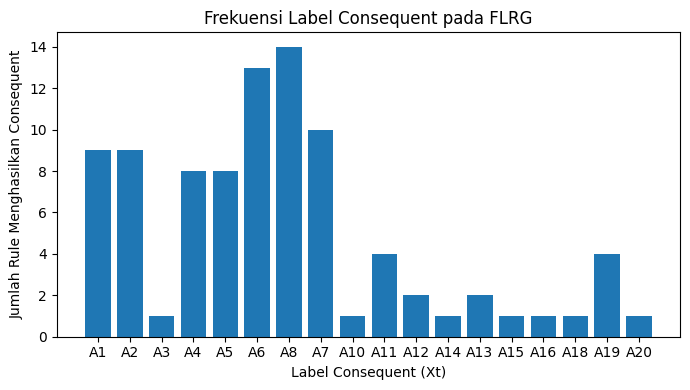

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(label_flr_counts.keys(), label_flr_counts.values())
plt.title("Frekuensi Label Consequent pada FLRG")
plt.xlabel("Label Consequent (Xt)")
plt.ylabel("Jumlah Rule Menghasilkan Consequent")
plt.tight_layout()
plt.show()

## FLRG

In [ ]:
# ----------------------------
# 4) Helper: build FLRG using X1..X5 labels + previous Xt labels
# ----------------------------
def build_labels_for_intervals(scaled_df, n_int):
    edges = {}
    labels = {}
    for col in scaled_df.columns:
        edges[col] = build_intervals(scaled_df[col], n_int)
        labels[col] = [fuzzify_value(v, edges[col]) for v in scaled_df[col]]
    return edges, labels


Mengubah data hasil scaling menjadi label fuzzy berdasarkan jumlah interval yang ditentukan. Pertama, fungsi build_intervals() menghasilkan batas-batas interval (edges) untuk setiap kolom. Lalu, setiap nilai pada kolom tersebut dikonversi menjadi label fuzzy menggunakan fuzzify_value(). Hasil akhirnya adalah daftar label fuzzy untuk masing-masing variabel (labels[col]), yang akan menjadi dasar pembentukan aturan fuzzy (FLRG). Dengan cara ini, data numerik diubah menjadi representasi linguistik yang lebih mudah dipakai dalam logika fuzzy.

## GRID SEARCH TUNING

In [ ]:
# ----------------------------
# 5) Grid search auto-tuning (FTS multifactor tanpa PCA, hanya order=0)
# ----------------------------
best_config = None
best_mape = np.inf
results_log = []

start_time = time.time()
total_runs = len(n_interval_range)
run_count = 0

print("\n=== MULAI GRID SEARCH AUTOTUNE (FTS MULTIFACTOR NO PCA, ORDER = 0 SAJA) ===")

# hanya order 0
for n_int in n_interval_range:
    run_count += 1
    print(f"\nRun {run_count}/{total_runs} - n_interval={n_int}, order=0")

    # ----------------------------
    # Bangun interval dan label fuzzy untuk seluruh kolom
    # ----------------------------
    edges_all, labels_all = build_labels_for_intervals(
        scaled[['X1', 'X2', 'X3', 'X4', 'X5', 'Xt']], n_int
    )
    Xt_labels = labels_all['Xt']
    factor_labels = {f"X{i}": labels_all[f"X{i}"] for i in range(1, 6)}

    # ----------------------------
    # Bangun FLRG (tanpa lag)
    # key = (X1_t, X2_t, X3_t, X4_t, X5_t) -> Xt_t
    # ----------------------------
    FLRG = {}
    for t in range(1, len(monthly_df)):
        key_factors = [factor_labels[f"X{i}"][t] for i in range(1, 6)]
        key = tuple(key_factors)
        tgt = Xt_labels[t]

        if key not in FLRG:
            FLRG[key] = []
        if tgt not in FLRG[key]:
            FLRG[key].append(tgt)

    # ----------------------------
    # Hitung pusat (center) interval Xt
    # ----------------------------
    centers_Xt = [
        (edges_all['Xt'][i] + edges_all['Xt'][i + 1]) / 2
        for i in range(len(edges_all['Xt']) - 1)
    ]
    center_dict_Xt = {f"A{i + 1}": centers_Xt[i] for i in range(len(centers_Xt))}

    # ----------------------------
    # Forecast historis (tanpa lag)
    # ----------------------------
    forecast_hist_scaled = []
    for t in range(1, len(monthly_df)):
        key_factors = [factor_labels[f"X{i}"][t] for i in range(1, 6)]
        key = tuple(key_factors)
        if key in FLRG:
            next_labels = FLRG[key]
            next_center = np.mean([center_dict_Xt[l] for l in next_labels])
        else:
            # fallback: pakai pusat label Xt terakhir yang diketahui
            prev_label = Xt_labels[t - 1]
            next_center = center_dict_Xt[prev_label]
        forecast_hist_scaled.append(next_center)

    # ----------------------------
    # Transformasi balik ke skala asli
    # ----------------------------
    forecast_hist_real = inverse_transform_array(scalers['Xt'], forecast_hist_scaled)
    actual_hist = monthly_df['Xt'].iloc[1:].values

    if len(actual_hist) < 2:
        print("  - Tidak cukup data historis untuk menghitung metrik. Lewati.")
        continue

    # ----------------------------
    # Evaluasi metrik
    # ----------------------------
    this_mape = mape(actual_hist, forecast_hist_real)
    this_mae = mean_absolute_error(actual_hist, forecast_hist_real)
    results_log.append({
        'n_interval': n_int,
        'MAPE': this_mape,
        'MAE': this_mae
    })

    print(f"  -> MAPE = {this_mape:.4f} %, MAE = {this_mae:.4f}")

    # ----------------------------
    # Simpan konfigurasi terbaik sementara
    # ----------------------------
    if this_mape < best_mape:
        best_mape = this_mape
        best_config = {
            'n_interval': n_int,
            'edges_all': edges_all,
            'FLRG': FLRG,
            'center_dict_Xt': center_dict_Xt,
            'labels_all': labels_all,
            'order': 0 # Add order here
        }

# ----------------------------
# Simpan hasil tuning
# ----------------------------
pd.DataFrame(results_log).to_csv("autotune_results_log_no_pca.csv", index=False)
elapsed = time.time() - start_time
print(f"\nGrid search selesai dalam {elapsed:.1f}s. Best MAPE = {best_mape:.4f}")
print("Saved autotune_results_log_no_pca.csv")

if best_config is None:
    raise RuntimeError("Tidak ditemukan konfigurasi terbaik. Periksa data dan parameter interval.")

# ----------------------------
# Simpan hasil fuzzifikasi dan FLRG terbaik
# ----------------------------
print("\nMenyimpan hasil fuzzifikasi & FLRG terbaik...")
pd.DataFrame(best_config['labels_all']).to_csv("fuzzified_data_best_no_pca.csv", index=False)

flrg_rows = []
for k, v in best_config['FLRG'].items():
    flrg_rows.append({
        'Antecedent (X1..X5)': ' , '.join(k),
        'Consequent (Xt)': ' , '.join(v)
    })
pd.DataFrame(flrg_rows).to_csv("FLRG_best_no_pca.csv", index=False)

print("Saved: fuzzified_data_best_no_pca.csv dan FLRG_best_no_pca.csv")


=== MULAI GRID SEARCH AUTOTUNE (FTS MULTIFACTOR NO PCA, ORDER = 0 SAJA) ===

Run 1/15 - n_interval=6, order=0
  -> MAPE = 6.6594 %, MAE = 58676.4936

Run 2/15 - n_interval=7, order=0
  -> MAPE = 5.0333 %, MAE = 43592.8391

Run 3/15 - n_interval=8, order=0
  -> MAPE = 4.2167 %, MAE = 38750.6133

Run 4/15 - n_interval=9, order=0
  -> MAPE = 3.7214 %, MAE = 33865.7137

Run 5/15 - n_interval=10, order=0
  -> MAPE = 3.3336 %, MAE = 29550.4005

Run 6/15 - n_interval=11, order=0
  -> MAPE = 3.5749 %, MAE = 32156.4540

Run 7/15 - n_interval=12, order=0
  -> MAPE = 2.9161 %, MAE = 25461.8837

Run 8/15 - n_interval=13, order=0
  -> MAPE = 3.0899 %, MAE = 27477.4510

Run 9/15 - n_interval=14, order=0
  -> MAPE = 2.9458 %, MAE = 26909.9313

Run 10/15 - n_interval=15, order=0
  -> MAPE = 2.1420 %, MAE = 19261.8026

Run 11/15 - n_interval=16, order=0
  -> MAPE = 2.0956 %, MAE = 19552.4825

Run 12/15 - n_interval=17, order=0
  -> MAPE = 2.0162 %, MAE = 18658.2130

Run 13/15 - n_interval=18, order=0


Tahap ini melakukan pencarian konfigurasi terbaik untuk jumlah interval fuzzy (n_interval) dengan mencoba berbagai nilai antara 6 hingga 20. Untuk setiap jumlah interval, model fuzzy dibangun ulang dan dihitung nilai error-nya (MAPE dan MAE). Secara garis besar, langkah-langkahnya adalah: membuat interval dan label fuzzy untuk semua variabel, membentuk aturan fuzzy (FLRG) berdasarkan kombinasi label faktor (X1–X5), lalu menggunakan aturan tersebut untuk memprediksi nilai Xt. Jika kombinasi faktor belum pernah muncul, model menggunakan fallback ke label sebelumnya. Prediksi dalam bentuk label dikonversi kembali ke nilai numerik menggunakan pusat interval (center). Hasil akhirnya dibandingkan dengan data aktual untuk menghitung error. Dari output yang ditampilkan, MAPE terbaik (sekitar 1.64%) diperoleh ketika jumlah interval = 20, menunjukkan bahwa model dengan interval lebih banyak mampu menangkap variasi data lebih halus.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# === 1. Tampilkan Hasil Tuning Intervals (autotune_results_log_no_pca.csv)
results_log = pd.read_csv("autotune_results_log_no_pca.csv")
print("==== Tabel Hasil Grid Search Tuning Interval ====")
print(results_log.head(20))   # Print 10 besar


==== Tabel Hasil Grid Search Tuning Interval ====
    n_interval      MAPE           MAE
0            6  6.659377  58676.493590
1            7  5.033291  43592.839089
2            8  4.216734  38750.613324
3            9  3.721444  33865.713675
4           10  3.333610  29550.400549
5           11  3.574889  32156.454046
6           12  2.916123  25461.883700
7           13  3.089925  27477.450972
8           14  2.945794  26909.931319
9           15  2.142038  19261.802564
10          16  2.095565  19552.482486
11          17  2.016193  18658.212993
12          18  1.762218  16051.578449
13          19  1.709926  15522.786293
14          20  1.645227  15039.006319


## FUZZIFIKASI

In [ ]:
# ----------------------------
# 5b) Simpan hasil fuzzifikasi dan FLRG terbaik
# ----------------------------
print("\n=== HASIL FUZZIFIKASI (contoh) ===")
fuzz_df = pd.DataFrame(best_config['labels_all'])
fuzz_df['month'] = monthly_df['month']
cols = ['month'] + [c for c in fuzz_df.columns if c != 'month']
fuzz_df = fuzz_df[cols]
print(fuzz_df.head(10))
fuzz_df.to_csv("fuzzification_result_no_pca.csv", index=False)
print("Saved fuzzification_result_no_pca.csv")

# ----------------------------
# FLRG terbaik (best_config['FLRG'])
# ----------------------------
flrg_best = best_config['FLRG']
flrg_rows = []
for antecedent, consequents in flrg_best.items():
    antecedent_str = ', '.join(antecedent)
    consequent_str = ', '.join(consequents)
    flrg_rows.append({'Antecedent': antecedent_str, 'Consequent': consequent_str})
flrg_df = pd.DataFrame(flrg_rows)
flrg_df.to_csv("flrg_best_no_pca.csv", index=False)

print("\n=== CONTOH FLRG TERBAIK (10 RULE) ===")
print(flrg_df.head(10))
print("Saved flrg_best_no_pca.csv")


=== HASIL FUZZIFIKASI (contoh) ===
       month   X1   X2   X3   X4   X5  Xt
0 2018-01-01  A12   A6   A4   A1   A9  A1
1 2018-02-01  A12   A6   A4   A3   A9  A1
2 2018-03-01  A13   A6   A3   A3   A9  A1
3 2018-04-01  A13   A6   A3   A4  A10  A1
4 2018-05-01  A12   A8   A5   A4  A10  A1
5 2018-06-01  A12  A10   A6   A6  A12  A1
6 2018-07-01  A12  A11   A7   A7  A11  A1
7 2018-08-01  A12  A15   A9   A9  A11  A1
8 2018-09-01  A11  A17  A10  A10  A12  A1
9 2018-10-01  A12  A17   A9  A12  A11  A1
Saved fuzzification_result_no_pca.csv

=== CONTOH FLRG TERBAIK (10 RULE) ===
                Antecedent Consequent
0      A12, A6, A4, A3, A9         A1
1      A13, A6, A3, A3, A9         A1
2     A13, A6, A3, A4, A10         A1
3     A12, A8, A5, A4, A10         A1
4    A12, A10, A6, A6, A12         A1
5    A12, A11, A7, A7, A11         A1
6    A12, A15, A9, A9, A11         A1
7  A11, A17, A10, A10, A12         A1
8   A12, A17, A9, A12, A11         A1
9    A12, A19, A10, A6, A7         A2
Saved f

ontoh hasil proses fuzzifikasi dan aturan fuzzy (FLRG) yang terbentuk. Tabel fuzzifikasi menunjukkan label fuzzy yang diberikan pada setiap bulan untuk setiap variabel (X1–X5 dan Xt), misalnya “A12, A6, A4, A3, A9 → A1”. Ini berarti bahwa jika kombinasi nilai faktor berada di interval A12, A6, A4, A3, dan A9, maka nilai Xt cenderung berada di interval A1. Label “A1” sampai “A20” merepresentasikan posisi relatif nilai dalam skala 0–1. Hasil FLRG ini menjadi basis logika fuzzy yang digunakan untuk melakukan peramalan. Semakin banyak kombinasi faktor yang unik, semakin besar pula kompleksitas aturan yang terbentuk, yang bisa mengarah ke sparseness (aturan muncul hanya sekali).

## FORECASTING

In [ ]:
# Buat DataFrame histori prediksi dan aktual
forecast_hist_df = pd.DataFrame({
    'month': monthly_df['month'].iloc[1:].reset_index(drop=True),
    'actual': monthly_df['Xt'].iloc[1:].reset_index(drop=True),
    'forecast': forecast_hist_real
})

In [ ]:
print(forecast_hist_df)

        month     actual     forecast
0  2018-02-01   579873.0   601169.425
1  2018-03-01   583934.0   601169.425
2  2018-04-01   594163.0   601169.425
3  2018-05-01   589993.0   601169.425
4  2018-06-01   582150.0   601169.425
..        ...        ...          ...
86 2025-04-01  1745782.0  1731800.725
87 2025-05-01  1731187.0  1731800.725
88 2025-06-01  1722603.0  1731800.725
89 2025-07-01  1738511.0  1731800.725
90 2025-08-01  1826020.0  1794613.575

[91 rows x 3 columns]


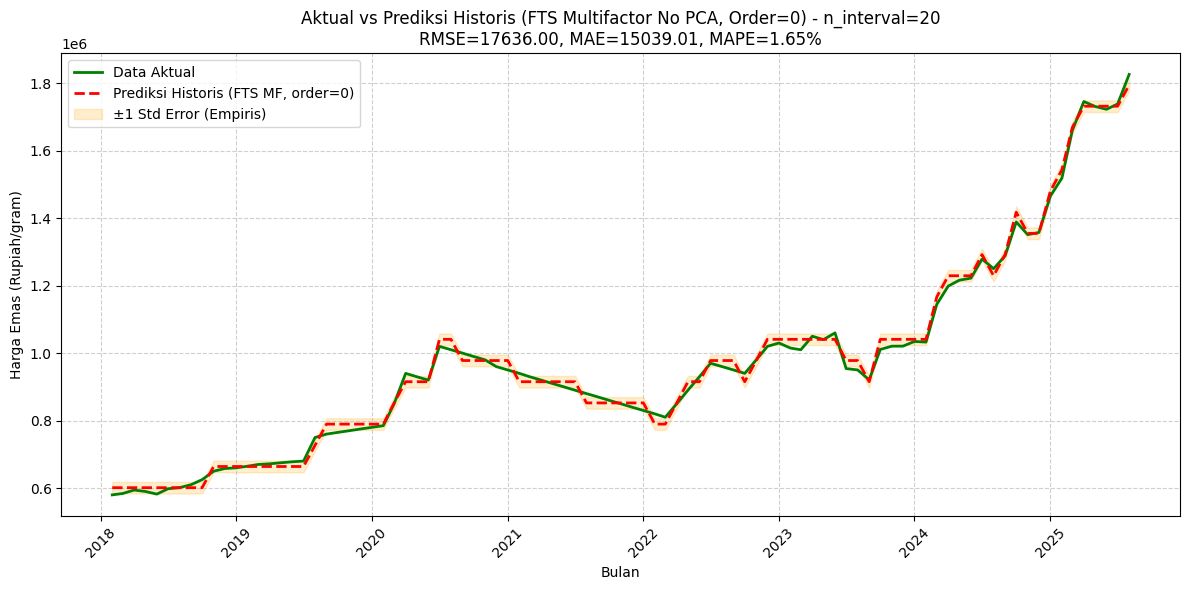

Saved plot_actual_vs_forecast_historical_no_pca_order0_WITH_CI.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ambil forecast & actual, index sudah dicek sama (pastikan monthly_df dan forecast_hist_df sinkron)
actual_hist = monthly_df['Xt'].iloc[1:].reset_index(drop=True).values
forecast_hist_real = forecast_hist_df['forecast'].values
months_series = forecast_hist_df['month'].values

# Hitung metric REAL (MAE, RMSE, MAPE)
rmse = np.sqrt(np.mean((actual_hist - forecast_hist_real) ** 2))
mae = np.mean(np.abs(actual_hist - forecast_hist_real))
mape_val = np.mean(np.abs((actual_hist - forecast_hist_real) / actual_hist)) * 100

# Hitung residual & confidence band (±1 std resid)
resid = actual_hist - forecast_hist_real
std_error = np.std(resid, ddof=1)
lower = forecast_hist_real - std_error
upper = forecast_hist_real + std_error

plt.figure(figsize=(12,6))
plt.plot(months_series, actual_hist, label='Data Aktual', color='green', linewidth=2)
plt.plot(months_series, forecast_hist_real, label='Prediksi Historis (FTS MF, order=0)', color='red', linestyle='--', linewidth=2)
plt.fill_between(months_series, lower, upper, color='orange', alpha=0.2, label='±1 Std Error (Empiris)')
plt.title(f'Aktual vs Prediksi Historis (FTS Multifactor No PCA, Order=0) - n_interval={best_config["n_interval"]}\nRMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape_val:.2f}%')
plt.xlabel('Bulan')
plt.ylabel('Harga Emas (Rupiah/gram)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plot_actual_vs_forecast_historical_no_pca_order0_WITH_CI.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved plot_actual_vs_forecast_historical_no_pca_order0_WITH_CI.png")


In [ ]:
import numpy as np
import pandas as pd

# Misal: future_steps = 12
future_steps = 12

# Buat array bulan ke depan
last_month = monthly_df['month'].iloc[-1]
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')

# Ambil factor_labels terakhir (persistensi)
last_factor_labels = [factor_labels[f"X{i}"][-1] for i in range(1,6)]

# Setting bound interval dan skala
scaled_min = edges_all['Xt'][0]
scaled_max = edges_all['Xt'][-1]
std_error_scaled = 0.1  # ganti dengan hasil std error scaled forecasting kamu

future_forecast_scaled = []
future_labels = []

for i in range(future_steps):
    key = tuple(last_factor_labels)
    if key in FLRG:
        next_labels = FLRG[key]
        next_center_scaled = np.mean([center_dict_Xt[l] for l in next_labels])
    else:
        prev_label = Xt_labels[-1]
        next_center_scaled = center_dict_Xt[prev_label]
    # Optional: tambahkan noise agar forecast tidak flat
    noise = np.random.normal(0, std_error_scaled * 0.3)
    next_center_scaled += noise
    next_center_scaled = np.clip(next_center_scaled, scaled_min * 0.95, scaled_max * 1.05)

    future_forecast_scaled.append(next_center_scaled)
    future_labels.append(fuzzify_value(next_center_scaled, edges_all['Xt']))

# Transform ke skala asli
future_forecast_real = inverse_transform_array(scalers['Xt'], future_forecast_scaled)

# Buat bounds (confidence interval)
z_value = 2 # untuk 95% CI (standar normal)
std_error_real = np.std(future_forecast_real) if len(future_forecast_real) > 1 else 1e-3
upper_future = future_forecast_real + z_value * std_error_real
lower_future = np.maximum(0, future_forecast_real - z_value * std_error_real)


In [ ]:
future_df = pd.DataFrame({
    'month': future_months,
    'forecast_value': future_forecast_real,  # hasil forecast asli
    'fuzzy_label': future_labels,
    'upper_bound': upper_future,   # interval atas
    'lower_bound': lower_future    # interval bawah
})


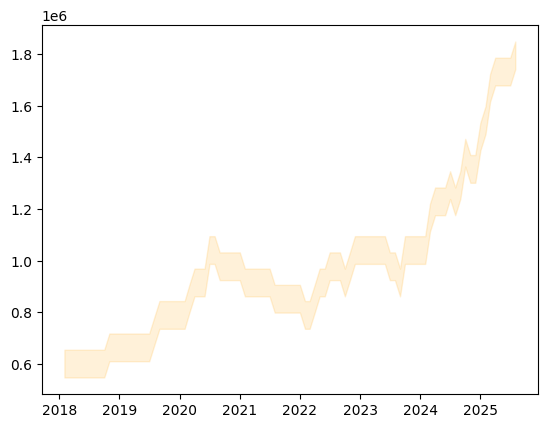

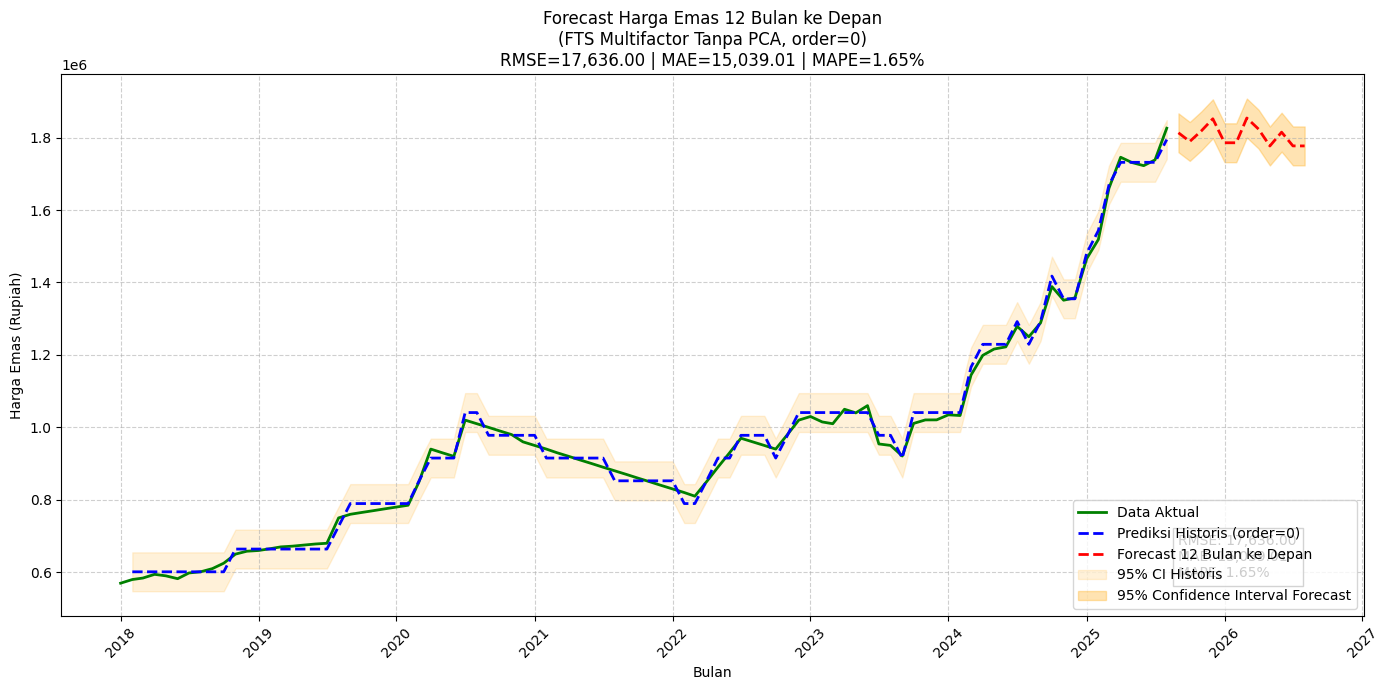

Saved plot_forecast_12bulan_no_pca_dynamic_v2.png


In [ ]:
# Hitung CI historis
ci_hist_upper = forecast_hist_df['forecast'] + z_value * std_error_real
ci_hist_lower = forecast_hist_df['forecast'] - z_value * std_error_real

plt.fill_between(forecast_hist_df['month'], ci_hist_lower, ci_hist_upper, color="orange", alpha=0.15, label="95% CI Historis")

import matplotlib.pyplot as plt
import math

plt.figure(figsize=(14, 7))

plt.plot(monthly_df['month'], monthly_df['Xt'], label="Data Aktual", color="green", linewidth=2)
plt.plot(forecast_hist_df['month'], forecast_hist_df['forecast'], label=f"Prediksi Historis (order={best_config['order']})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_df['month'], future_df['forecast_value'], label="Forecast 12 Bulan ke Depan", color="red", linestyle="--", linewidth=2)

# CI Historis
plt.fill_between(forecast_hist_df['month'], ci_hist_lower, ci_hist_upper, color="orange", alpha=0.15, label="95% CI Historis")
# CI Forecast
plt.fill_between(future_df['month'], future_df['lower_bound'], future_df['upper_bound'], color="orange", alpha=0.3, label="95% Confidence Interval Forecast")

plt.title(
    f"Forecast Harga Emas 12 Bulan ke Depan\n"
    f"(FTS Multifactor Tanpa PCA, order={best_config['order']})\n"
    f"RMSE={rmse:,.2f} | MAE={mae:,.2f} | MAPE={mape_val:.2f}%"
)
plt.xlabel("Bulan")
plt.ylabel("Harga Emas (Rupiah)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="lower right")
plt.xticks(rotation=45)

# Metrics box di sudut bawah kanan
ymin = min(monthly_df['Xt'].min(), future_df['lower_bound'].min())
plt.text(
    future_df['month'].iloc[0], ymin * 1.03,
    f"RMSE: {rmse:,.2f}\nMAE: {mae:,.2f}\nMAPE: {mape_val:.2f}%",
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.85)
)

plt.tight_layout()
plt.savefig("plot_forecast_12bulan_no_pca_dynamic_v2.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved plot_forecast_12bulan_no_pca_dynamic_v2.png")


## RESIDUAL

In [ ]:
# Pastikan forecast_hist_df sudah dibuat (lihat jawaban sebelumnya)
# Ini variabel residual historis
resid_real = forecast_hist_df['actual'].values - forecast_hist_df['forecast'].values

# Jika scaling ada (misal MinMaxScaler)
try:
    resid_scaled = scalers['Xt'].transform(resid_real.reshape(-1,1)).flatten()
    std_error_scaled = np.std(resid_scaled, ddof=1)
except Exception:
    std_error_scaled = 0.0  # Jika scaling tidak tersedia
std_error_real = np.std(resid_real, ddof=1)


Menghitung nilai residual, yaitu selisih antara data aktual dan hasil prediksi model pada periode historis. Residual menunjukkan seberapa besar kesalahan model dalam melakukan peramalan. Jika residual bernilai positif, artinya model cenderung meremehkan nilai aktual (underestimate), sedangkan residual negatif menunjukkan model melebihkan prediksi (overestimate). Nilai residual ini nantinya digunakan untuk berbagai analisis diagnostik, seperti normalitas, autokorelasi, dan kestabilan model.

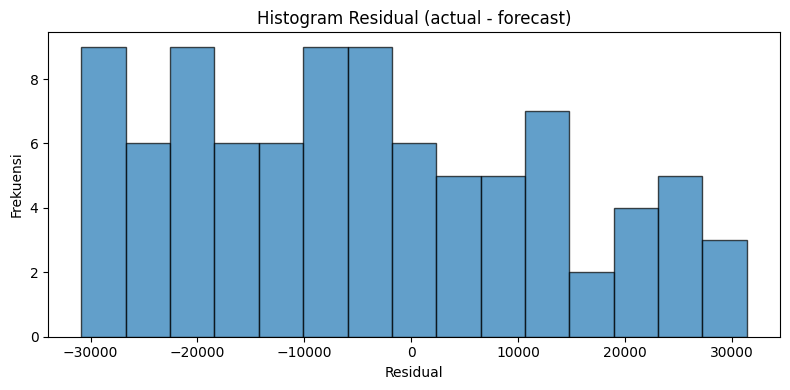

Saved residual_histogram_no_pca_order0.png


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(resid_real, bins=15, edgecolor='k', alpha=0.7)
plt.title("Histogram Residual (actual - forecast)")
plt.xlabel("Residual")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig("residual_histogram_no_pca_order0.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved residual_histogram_no_pca_order0.png")


Menampilkan histogram residual untuk melihat distribusi penyebaran kesalahan prediksi. Histogram membantu kita memahami apakah error model cenderung simetris (mendekati normal) atau justru miring ke satu sisi (skewed). Distribusi yang simetris menandakan bahwa model tidak bias ke atas atau ke bawah, sedangkan distribusi yang miring menandakan adanya kecenderungan tertentu. Misalnya, model sering meremehkan atau melebihkan hasil. Grafik ini juga berguna untuk mendeteksi keberadaan outlier, yaitu titik error yang sangat ekstrem dibanding data lain.

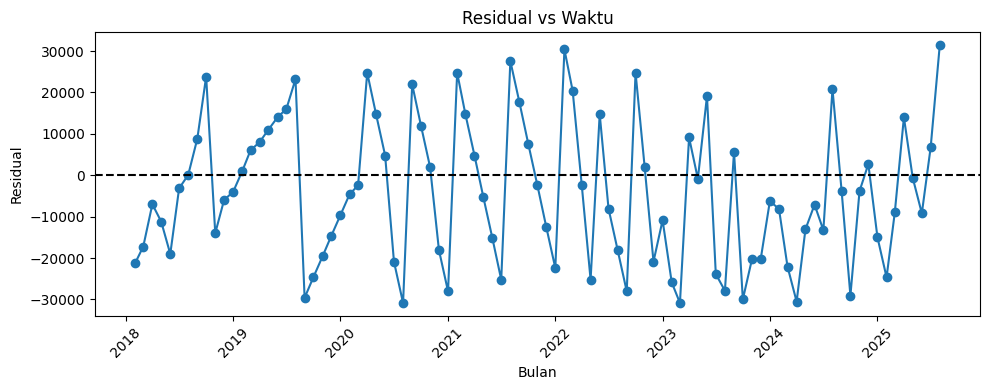

Saved residual_vs_time_no_pca_order0.png


In [ ]:
plt.figure(figsize=(10,4))
plt.plot(forecast_hist_df['month'], resid_real, marker='o', linestyle='-')
plt.axhline(0, color='k', linestyle='--')
plt.title("Residual vs Waktu")
plt.xlabel("Bulan")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("residual_vs_time_no_pca_order0.png", dpi=200, bbox_inches='tight')
plt.show()
print("Saved residual_vs_time_no_pca_order0.png")


Menampilkan grafik residual terhadap waktu untuk melihat apakah kesalahan model bersifat acak atau mengikuti pola tertentu. Residual yang menyebar secara acak di sekitar garis nol menandakan bahwa model bekerja dengan cukup baik, tanpa pola sistematis. Namun, jika residual menunjukkan tren naik-turun yang teratur atau membentuk pola tertentu, hal itu mengindikasikan bahwa model mungkin belum menangkap seluruh dinamika data (misalnya ada unsur tren atau musiman yang belum dimodelkan). Grafik ini penting untuk mendeteksi bias temporal atau ketidakkonsistenan model dari waktu ke waktu.

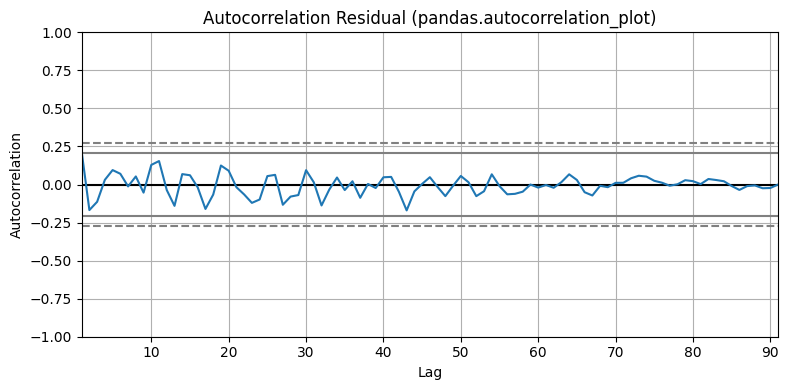

Saved residual_acf_no_pca_order0.png


In [ ]:
try:
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(8,4))
    autocorrelation_plot(pd.Series(resid_real))
    plt.title("Autocorrelation Residual (pandas.autocorrelation_plot)")
    plt.tight_layout()
    plt.savefig("residual_acf_no_pca_order0.png", dpi=200, bbox_inches='tight')
    plt.show()
    print("Saved residual_acf_no_pca_order0.png")
except Exception as e:
    print("Autocorrelation plot gagal:", e)


Menghasilkan plot autokorelasi (ACF) dari residual untuk memeriksa apakah kesalahan model pada satu waktu berkaitan dengan kesalahan pada waktu sebelumnya. Idealnya, residual bersifat acak (tidak berkorelasi), yang berarti model sudah berhasil menangkap seluruh pola yang ada di data. Namun, jika muncul batang (bar) yang signifikan pada lag tertentu, itu menunjukkan adanya autokorelasi, atau dengan kata lain, masih ada pola berulang dalam residual yang belum dipelajari oleh model. Hal ini biasanya menjadi indikasi bahwa model perlu diperbaiki, misalnya dengan menambah komponen lag (order > 0).

In [ ]:
try:
    from scipy.stats import normaltest
    stat, pval = normaltest(resid_real)
    print(f"Normality test (D'Agostino): stat={stat:.4f}, p-value={pval:.4f}")
except Exception as e:
    print("Normality test tidak tersedia (scipy missing) atau gagal:", e)

# Summarize diagnostics
rmse = np.sqrt(np.mean((forecast_hist_df['actual'] - forecast_hist_df['forecast']) ** 2))
mae = np.mean(np.abs(forecast_hist_df['actual'] - forecast_hist_df['forecast']))
mape_val = np.mean(np.abs((forecast_hist_df['actual'] - forecast_hist_df['forecast']) / forecast_hist_df['actual'])) * 100
diag_summary = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape_val,
    'StdErrorReal': std_error_real,
    'StdErrorScaled': std_error_scaled,
    'n_interval_best': best_config['n_interval'],
    'order': best_config['order']
}
pd.Series(diag_summary).to_csv("diagnostics_summary_no_pca_order0.csv", header=False)
print("Saved diagnostics_summary_no_pca_order0.csv")


Normality test (D'Agostino): stat=12.0098, p-value=0.0025
Saved diagnostics_summary_no_pca_order0.csv


Melakukan uji normalitas menggunakan metode D’Agostino test, untuk memeriksa apakah residual terdistribusi normal atau tidak. Hasil uji berupa nilai statistik dan p-value. Jika p-value < 0.05, maka kita menolak hipotesis nol bahwa residual berdistribusi normal, artinya residual tidak mengikuti distribusi normal. Terakhir, menghitung berbagai metrik evaluasi seperti RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), dan MAPE (Mean Absolute Percentage Error).



## Tambahan Kode (optional)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# === 1. Tampilkan Hasil Tuning Intervals (autotune_results_log_no_pca.csv)
results_log = pd.read_csv("autotune_results_log_no_pca.csv")
print("==== Tabel Hasil Grid Search Tuning Interval ====")
print(results_log.head(20))   # Print 10 besar


==== Tabel Hasil Grid Search Tuning Interval ====
    n_interval      MAPE           MAE
0            6  6.659377  58676.493590
1            7  5.033291  43592.839089
2            8  4.216734  38750.613324
3            9  3.721444  33865.713675
4           10  3.333610  29550.400549
5           11  3.574889  32156.454046
6           12  2.916123  25461.883700
7           13  3.089925  27477.450972
8           14  2.945794  26909.931319
9           15  2.142038  19261.802564
10          16  2.095565  19552.482486
11          17  2.016193  18658.212993
12          18  1.762218  16051.578449
13          19  1.709926  15522.786293
14          20  1.645227  15039.006319


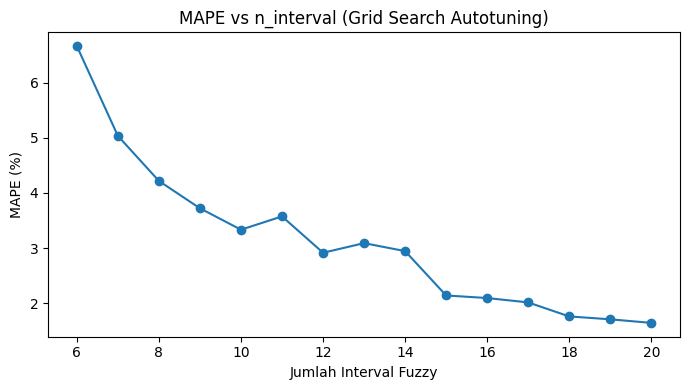

In [ ]:
# Plot MAPE vs n_interval
plt.figure(figsize=(7,4))
plt.plot(results_log['n_interval'], results_log['MAPE'], marker='o')
plt.title("MAPE vs n_interval (Grid Search Autotuning)")
plt.xlabel("Jumlah Interval Fuzzy")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.savefig("plot_mape_vs_ninterval.png", dpi=200)
plt.show()

In [ ]:
# === 2. Tampilkan Contoh Fuzzifikasi ===
fuzzified = pd.read_csv("fuzzified_data_best_no_pca.csv")
print("==== Contoh Tabel Fuzzifikasi (5 baris) ====")
print(fuzzified.head())

==== Contoh Tabel Fuzzifikasi (5 baris) ====
    X1  X2  X3  X4   X5  Xt
0  A12  A6  A4  A1   A9  A1
1  A12  A6  A4  A3   A9  A1
2  A13  A6  A3  A3   A9  A1
3  A13  A6  A3  A4  A10  A1
4  A12  A8  A5  A4  A10  A1


In [ ]:
# === 3. Tampilkan Contoh FLRG (Rule) ===
flrg = pd.read_csv("FLRG_best_no_pca.csv")
print("==== Contoh Tabel FLRG (5 baris) ====")
print(flrg.head())

==== Contoh Tabel FLRG (5 baris) ====
         Antecedent (X1..X5) Consequent (Xt)
0    A12 , A6 , A4 , A3 , A9              A1
1    A13 , A6 , A3 , A3 , A9              A1
2   A13 , A6 , A3 , A4 , A10              A1
3   A12 , A8 , A5 , A4 , A10              A1
4  A12 , A10 , A6 , A6 , A12              A1


In [ ]:
forecast_hist_df.to_csv("forecast_historis_fts_no_pca.csv", index=False)
print("Saved forecast_historis_fts_no_pca.csv")

Saved forecast_historis_fts_no_pca.csv


In [ ]:
future_df.to_csv("forecast_future_12bulan_fts_no_pca.csv", index=False)
print("Saved forecast_future_12bulan_fts_no_pca.csv")

Saved forecast_future_12bulan_fts_no_pca.csv


In [ ]:
# === 5. Tabel dan Plot Forecast 12 Bulan Ke Depan ===
future_df = pd.read_csv("forecast_future_12bulan_fts_no_pca.csv")
print("==== Forecast 12 Bulan ke Depan (5 baris awal) ====")
print(future_df.head())

==== Forecast 12 Bulan ke Depan (5 baris awal) ====
        month  forecast_value fuzzy_label   upper_bound   lower_bound
0  2025-09-01    1.813334e+06         A20  1.867043e+06  1.759624e+06
1  2025-10-01    1.789403e+06         A20  1.843112e+06  1.735693e+06
2  2025-11-01    1.819023e+06         A20  1.872733e+06  1.765314e+06
3  2025-12-01    1.852013e+06         A20  1.905722e+06  1.798304e+06
4  2026-01-01    1.785789e+06         A20  1.839498e+06  1.732080e+06


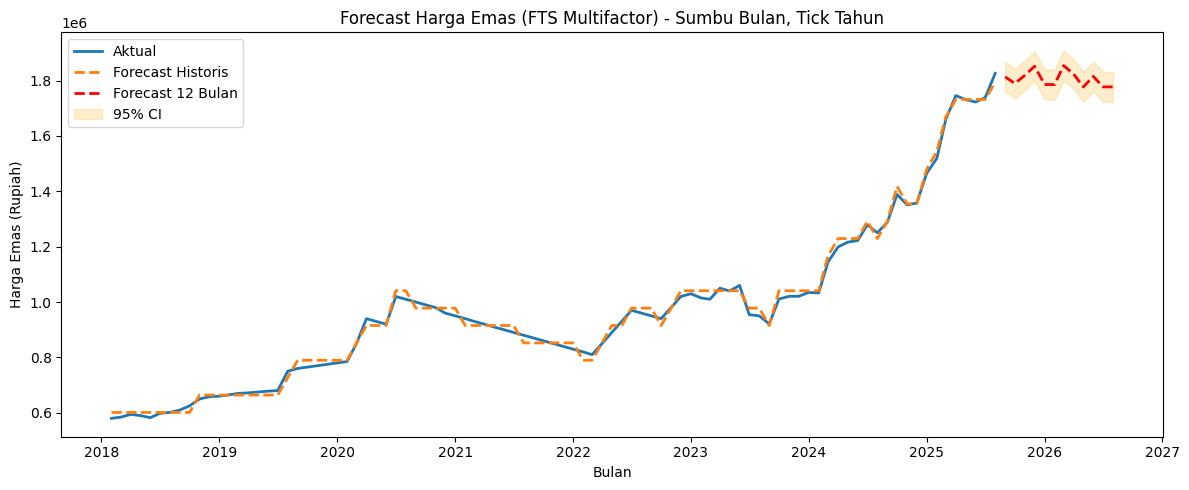

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan column 'month' bertipe datetime atau string ISO
forecast_hist_df['month'] = pd.to_datetime(forecast_hist_df['month'])
future_df['month'] = pd.to_datetime(future_df['month'])

plt.figure(figsize=(12,5))
plt.plot(forecast_hist_df['month'], forecast_hist_df['actual'], label='Aktual', linewidth=2)
plt.plot(forecast_hist_df['month'], forecast_hist_df['forecast'], label='Forecast Historis', linestyle='--', linewidth=2)
plt.plot(future_df['month'], future_df['forecast_value'], label='Forecast 12 Bulan', color='red', linestyle='--', linewidth=2)
plt.fill_between(future_df['month'], future_df['lower_bound'], future_df['upper_bound'], alpha=0.2, color='orange', label='95% CI')

plt.title("Forecast Harga Emas (FTS Multifactor) - Sumbu Bulan, Tick Tahun")
plt.xlabel("Bulan")
plt.ylabel("Harga Emas (Rupiah)")
plt.legend()
plt.tight_layout()

# Custom ticks: hanya tahun ditampilkan di axis
import matplotlib.dates as mdates
years = mdates.YearLocator()        # locator tahunan
years_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=0)

plt.savefig("plot_forecast_bulan_ticks_tahun.png", dpi=200)
plt.show()


In [ ]:
fuzzified = pd.read_csv("fuzzified_data_best_no_pca.csv")
# Asumsi target/cluster ada di kolom 'Xt'
total_clusters = fuzzified['Xt'].nunique()
print(f"Jumlah cluster fuzzy (interval) pada Xt: {total_clusters}")
for col in fuzzified.columns:
    print(f"Jumlah cluster pada {col}: {fuzzified[col].nunique()}")


Jumlah cluster fuzzy (interval) pada Xt: 18
Jumlah cluster pada X1: 17
Jumlah cluster pada X2: 12
Jumlah cluster pada X3: 19
Jumlah cluster pada X4: 20
Jumlah cluster pada X5: 18
Jumlah cluster pada Xt: 18


In [ ]:
flrg = pd.read_csv("FLRG_best_no_pca.csv")
total_flrg = len(flrg)
print(f"Jumlah FLRG (rule): {total_flrg}")


Jumlah FLRG (rule): 90


In [ ]:
flrg['num_consequents'] = flrg['Consequent (Xt)'].apply(lambda x: len(x.split(' , ')))
print("Distribusi jumlah consequent per rule:")
print(flrg['num_consequents'].value_counts())


Distribusi jumlah consequent per rule:
num_consequents
1    90
Name: count, dtype: int64


=== Jumlah kemunculan masing-masing label fuzzy pada Xt ===
Xt
A1     10
A10     1
A11     4
A12     2
A13     2
A14     1
A15     1
A16     1
A18     1
A19     4
A2      9
A20     1
A3      1
A4      8
A5      8
A6     13
A7     11
A8     14
Name: count, dtype: int64


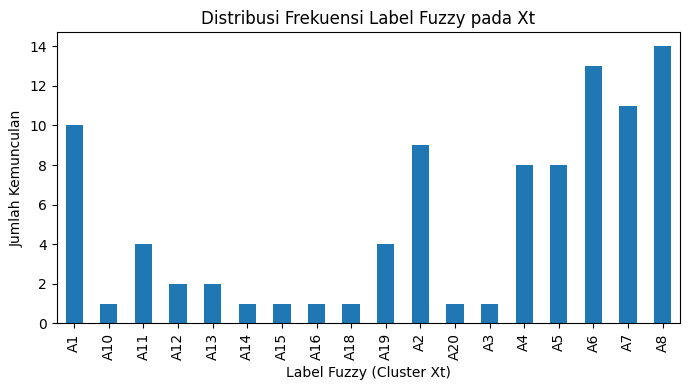

In [ ]:
fuzzified = pd.read_csv("fuzzified_data_best_no_pca.csv")

# Frekuensi tiap label fuzzy pada Xt (target)
label_counts_xt = fuzzified['Xt'].value_counts().sort_index()
print("=== Jumlah kemunculan masing-masing label fuzzy pada Xt ===")
print(label_counts_xt)

# Visual bar chart (opsional)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
label_counts_xt.plot(kind='bar')
plt.title("Distribusi Frekuensi Label Fuzzy pada Xt")
plt.xlabel("Label Fuzzy (Cluster Xt)")
plt.ylabel("Jumlah Kemunculan")
plt.tight_layout()
plt.show()


=== Jumlah kemunculan setiap label fuzzy Xt sebagai consequent di FLRG ===
A1: 9
A10: 1
A11: 4
A12: 2
A13: 2
A14: 1
A15: 1
A16: 1
A18: 1
A19: 4
A2: 9
A20: 1
A3: 1
A4: 8
A5: 8
A6: 13
A7: 10
A8: 14


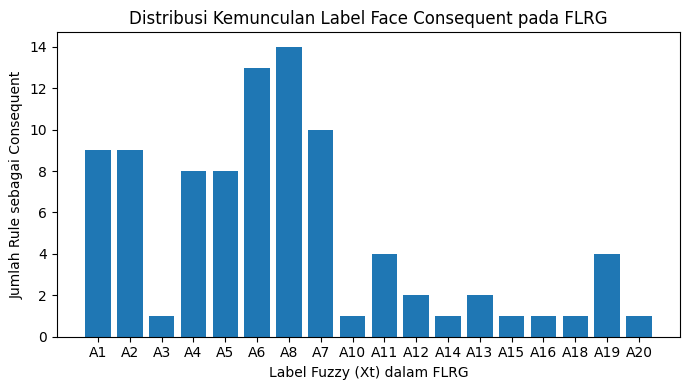

In [ ]:
flrg = pd.read_csv("FLRG_best_no_pca.csv")

# Split consequent jadi list
flrg['consequents'] = flrg['Consequent (Xt)'].apply(lambda x: [s.strip() for s in x.split(' , ')])

# Flatten semua consequent menjadi satu list
all_consequents = [item for sublist in flrg['consequents'] for item in sublist]

# Hitung frekuensi di seluruh rule
import collections
label_flr_counts = collections.Counter(all_consequents)
print("=== Jumlah kemunculan setiap label fuzzy Xt sebagai consequent di FLRG ===")
for label, count in sorted(label_flr_counts.items()):
    print(f"{label}: {count}")

# Visual bar chart (opsional)
plt.figure(figsize=(7,4))
plt.bar(label_flr_counts.keys(), label_flr_counts.values())
plt.title("Distribusi Kemunculan Label Face Consequent pada FLRG")
plt.xlabel("Label Fuzzy (Xt) dalam FLRG")
plt.ylabel("Jumlah Rule sebagai Consequent")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

## --- (a) Forecast historis ---
# Sudah ada forecast_hist_df: kolom ['month', 'actual', 'forecast']
forecast_hist_df['type'] = 'historis'
forecast_hist_df['upper_bound'] = np.nan
forecast_hist_df['lower_bound'] = np.nan

## --- (b) Forecast future ---
# Sudah ada future_df: kolom ['month', 'forecast_value', 'upper_bound', 'lower_bound']
future_df_rename = future_df.rename(columns={'forecast_value':'forecast'})
future_df_rename['actual'] = np.nan
future_df_rename['type'] = 'future'

# Kolom order: ['month', 'actual', 'forecast', 'lower_bound', 'upper_bound', 'type']
future_df_rename = future_df_rename[['month', 'actual', 'forecast', 'lower_bound', 'upper_bound', 'type']]
forecast_hist_df = forecast_hist_df[['month', 'actual', 'forecast', 'lower_bound', 'upper_bound', 'type']]

## --- (c) Gabung ---
df_all = pd.concat([forecast_hist_df, future_df_rename], ignore_index=True)
print(df_all.head(10))   # Sample gabungan

## --- (d) Save CSV utama ---
df_all.to_csv("gabungan_forecast_fts.csv", index=False)
print("Gabungan forecast historis & future disimpan sebagai gabungan_forecast_fts.csv")


       month    actual    forecast  lower_bound  upper_bound      type
0 2018-02-01  579873.0  601169.425          NaN          NaN  historis
1 2018-03-01  583934.0  601169.425          NaN          NaN  historis
2 2018-04-01  594163.0  601169.425          NaN          NaN  historis
3 2018-05-01  589993.0  601169.425          NaN          NaN  historis
4 2018-06-01  582150.0  601169.425          NaN          NaN  historis
5 2018-07-01  598000.0  601169.425          NaN          NaN  historis
6 2018-08-01  601250.0  601169.425          NaN          NaN  historis
7 2018-09-01  610000.0  601169.425          NaN          NaN  historis
8 2018-10-01  625000.0  601169.425          NaN          NaN  historis
9 2018-11-01  650000.0  663982.275          NaN          NaN  historis
Gabungan forecast historis & future disimpan sebagai gabungan_forecast_fts.csv


In [ ]:
import pandas as pd
import numpy as np

# 1. Data historis (tanpa aktual, bisa tambahkan fuzzy_label jika punya)
hist_df = pd.DataFrame({
    'month': monthly_df['month'].iloc[1:].reset_index(drop=True),
    'forecast': forecast_hist_real,
    # Optional: fuzzy_label_hist dapat ditambahkan jika ingin, sesuaikan variabelnya
    # 'fuzzy_label': forecast_label_hist,
    'upper_bound': np.nan,   # historis biasanya tanpa CI, isi NaN
    'lower_bound': np.nan
})

# 2. Data future (sudah ada kolom fuzzy_label & CI)
future_df = pd.DataFrame({
    'month': future_months,
    'forecast': future_forecast_real,  # pastikan nama kolomnya sama!
    'fuzzy_label': future_labels,
    'upper_bound': upper_future,
    'lower_bound': lower_future
})

# Jika ingin sama persis kolomnya:
future_df['upper_bound'] = future_df['upper_bound'].astype(float)
future_df['lower_bound'] = future_df['lower_bound'].astype(float)
if 'fuzzy_label' not in hist_df.columns and 'fuzzy_label' in future_df.columns:
    hist_df['fuzzy_label'] = np.nan
    # urutkan kolom
    cols = ['month', 'forecast', 'fuzzy_label', 'upper_bound', 'lower_bound']
    hist_df = hist_df[cols]
    future_df = future_df[cols]

# 3. Gabungkan
df_all_pred = pd.concat([hist_df, future_df], ignore_index=True)

print(df_all_pred.head(8), '\n...dst tail:\n', df_all_pred.tail(8))

# 4. Simpan (atau pakai DataFrame ini untuk plot/laporan)
df_all_pred.to_csv("prediksi_gabungan_fts.csv", index=False)


       month    forecast fuzzy_label  upper_bound  lower_bound
0 2018-02-01  601169.425         NaN          NaN          NaN
1 2018-03-01  601169.425         NaN          NaN          NaN
2 2018-04-01  601169.425         NaN          NaN          NaN
3 2018-05-01  601169.425         NaN          NaN          NaN
4 2018-06-01  601169.425         NaN          NaN          NaN
5 2018-07-01  601169.425         NaN          NaN          NaN
6 2018-08-01  601169.425         NaN          NaN          NaN
7 2018-09-01  601169.425         NaN          NaN          NaN 
...dst tail:
          month      forecast fuzzy_label   upper_bound   lower_bound
95  2026-01-01  1.785789e+06         A20  1.839498e+06  1.732080e+06
96  2026-02-01  1.785789e+06         A20  1.839499e+06  1.732080e+06
97  2026-03-01  1.854130e+06         A20  1.907840e+06  1.800421e+06
98  2026-04-01  1.823536e+06         A20  1.877246e+06  1.769827e+06
99  2026-05-01  1.776920e+06         A20  1.830629e+06  1.723211e+06
100 

In [ ]:
import pandas as pd
import numpy as np

# (1) --- Data bulan historis ---
# Jika data bulan/minggu sudah ada di dataframe asli:
# Contoh: monthly_df['month'] (pastikan kolom ini format string/timestamp)
forecast_hist_months = monthly_df['month'].iloc[1:].reset_index(drop=True)

# (2) --- Hasil forecast historis (skala asli, hasil inverse!)
# Contoh: forecast_hist_real harus sudah dihasilkan dari proses FTS
# forecast_hist_real = ... # array/list hasil inverse transform

# (3) --- Data bulan prediksi ke depan ---
# Contoh: future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=12, freq='MS')
# atau future_months = list atau array pd.Timestamp/str sesuai pipeline
# pastikan format konsisten (list atau array, dan klop jumlahnya dengan future_forecast_real)

# (4) --- Hasil forecast future (skala asli, hasil inverse!)
# Contoh: future_forecast_real = ... # list/array hasil inverse transform dari prediksi 12 bulan

# Cek dengan print (debug) jika perlu
print("- Data bulan historis: ", forecast_hist_months[:3], " dst...")
print("- Data forecast historis: ", forecast_hist_real[:3], " dst...")
print("- Data bulan future: ", future_months[:3], " dst...")
print("- Data forecast future: ", future_forecast_real[:3], " dst...")


- Data bulan historis:  0   2018-02-01
1   2018-03-01
2   2018-04-01
Name: month, dtype: datetime64[ns]  dst...
- Data forecast historis:  [601169.425 601169.425 601169.425]  dst...
- Data bulan future:  DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01'], dtype='datetime64[ns]', freq='MS')  dst...
- Data forecast future:  [1813333.59395158 1789402.71011411 1819023.47279426]  dst...


In [ ]:
all_months = list(forecast_hist_months) + list(future_months)
all_forecast = list(forecast_hist_real) + list(future_forecast_real)

df_forecast_only = pd.DataFrame({
    'month': all_months,
    'forecast': all_forecast
})

print(df_forecast_only.head())
print(df_forecast_only.tail())
df_forecast_only.to_csv("forecast_gabungan_month_forecast.csv", index=False)


       month    forecast
0 2018-02-01  601169.425
1 2018-03-01  601169.425
2 2018-04-01  601169.425
3 2018-05-01  601169.425
4 2018-06-01  601169.425
         month      forecast
98  2026-04-01  1.823536e+06
99  2026-05-01  1.776920e+06
100 2026-06-01  1.815061e+06
101 2026-07-01  1.777148e+06
102 2026-08-01  1.777061e+06


## Opsionalll

In [ ]:
# Pastikan monthly_df adalah dataframe utama yang berisi semua variabel (X1..X5, Xt)
def get_uod(series, margin_ratio=0):
    min_val = series.min()
    max_val = series.max()
    margin = (max_val - min_val) * margin_ratio
    return min_val - margin, max_val + margin

print("=== UoD (Universe of Discourse) per variabel ===")
uod_all = {}
for col in monthly_df.columns:
    uod_min, uod_max = get_uod(monthly_df[col], margin_ratio=0) # Bisa diubah margin_ratio kalau mau margin
    uod_all[col] = (uod_min, uod_max)
    print(f"{col}: {uod_min:.2f} .. {uod_max:.2f}")


=== UoD (Universe of Discourse) per variabel ===
month: .2f .. .2f
X1: -0.00 .. 0.06
X2: 0.04 .. 0.06
X3: 0.00 .. 0.06
X4: 13387.00 .. 16600.00
X5: 279962.40 .. 1674182.00
Xt: 569763.00 .. 1826020.00


In [ ]:
uod_df = pd.DataFrame([
    {'Variable': col, 'Min_UoD': vals[0], 'Max_UoD': vals[1]}
    for col, vals in uod_all.items()
])
print(uod_df)

  Variable              Min_UoD              Max_UoD
0    month  2018-01-01 00:00:00  2025-08-01 00:00:00
1       X1              -0.0009               0.0551
2       X2                0.035               0.0625
3       X3               0.0001               0.0584
4       X4              13387.0              16600.0
5       X5             279962.4            1674182.0
6       Xt             569763.0            1826020.0
